# Introduction

This notebook will be a summary of several test done on this project. During training, I had issues to train a stable U-Net "classic". In order to stabilize it, I decided to train it using 3 images as inputs with differents pré-processing (I'll call this model <b>U-Net extended</b>). In this Notebook, I'll share with you :

<ul>
<li>A quick exploration</li>
<li>The pre-processing for the U-net Extended</li>
<li>The model</li>
<li>The post-processing</li>
<li>The prediction Kaggle</li>
<li>A bonus</li>
</ul>

Let's go !

## Imports and functions

In order to simplify the reset of the Kernel, functions and imports are stacked on top

In [1]:
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import time

from collections import Counter
from shutil import copyfile
from PIL import Image
from IPython import display 
from sklearn.model_selection import train_test_split
from skimage.morphology import label
from itertools import groupby

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [2]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.optimizers import Adam, SGD
from keras import regularizers

import tensorflow as tf

Using TensorFlow backend.


Here, we will add all functions required for the notebook. This is just to load them easily when we restart the Kernel.

In [3]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def is_back_and_white(img):
    # detect f image is B&W or color
    a = np.array_equiv(image[:, :, 0], image[:, :, 1])
    b = np.array_equiv(image[:, :, 1], image[:, :, 2])
    return (a and b)

def boost_contrast(img):
    # equivalent of 255*MinMaxScaling function
    mini = img.min()
    maxi = img.max()
    return (img-mini)*(255/(maxi-mini))

def add_seuillage(img, level=100):
    # this function boost again contrasts and clip it to "ease" learning
    img = (img-level)*(255/(255-(2*level)))
    img = np.clip(img, 0, 255)
    return img

def prepare_image_final(image):
    # pre-process image
    if not is_back_and_white(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=50)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if gray.mean() > 150:
            gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=0)
    return gray

def resize_to_original(img, target_size):
    current_height, current_width = img.shape
    target_height, target_width = target_size
    if current_height >= target_height and current_width >= target_width:
        # we are in case where we expanded with black
        return img[:target_height, :target_width]
    else:
        scale = max(target_height, target_width) / 512
        scaled_image = cv2.resize(img, None, fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)
        return scaled_image[:target_height, :target_width]
    return img

def compute_IoU(pred, mask, trigger=0.999):
    pred = (pred>trigger)
    mask = (mask>0.9)
    union = np.logical_or(pred, mask)
    intersection = np.logical_and(pred, mask)
    return intersection.sum()/union.sum()

def img_to_rle(img):
    # I prefer groupby vs loop and Flatten('F') avoid the transpose
    result = []
    X = img.flatten('F').tolist()
    current_index = 1
    for k, g in groupby(X):
        l = len(list(g))
        if k > 0.5:
            result.append(current_index)
            result.append(l)
        current_index += l
    return result

"""
From Kaggle but I prefer groupby vs loop
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
"""

def prob_to_rles(x, cutoff=0.5):
    # From Kaggle
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        #yield rle_encoding(lab_img == i)
        yield img_to_rle(lab_img == i)
        
def pre_process_image(img):
    # generation of all 3 image inputs
    X3 = img
    X1 = prepare_image_final(X3)
    X2 = cv2.adaptiveThreshold(X1.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        
    # resize to 256 x 256 for prediction
    X1 = cv2.resize(X1, (256, 256))
    X2 = cv2.resize(X2, (256, 256))
    X3 = cv2.resize(X3, (256, 256))
    
    # transforamtion to proper type/shape
    X1 = np.expand_dims(X1, 3)
    X2 = np.expand_dims(X2, 3)
    X1 = np.expand_dims(X1, 0).astype(np.float32)
    X2 = np.expand_dims(X2, 0).astype(np.float32)
    X3 = np.expand_dims(X3, 0).astype(np.float32)
    
    # normalize
    X1 /= 255.
    X2 /= 255.
    X3 /= 255.
    
    return [X1, X2, X3]

def show(img, cmap="gray", title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap=cmap)
    if title is not None:
        plt.savefig("img/{}.png".format(title))
    plt.show()

# Exploration

For the exploration, I'll only share informations and not provide all the code as it is pretty easy. Feel free to contact me if you want link to the full notebook.

### Type of images

We have 3 kind of images, Black with White cells, White with Black cells or colored images

<img src="img/img_type.png">

### Dimensions of images

Most of images have a small ration W/H and have often the same size. We can see a scatter plot of dimensions. The size of the point reflect the number of images

<img src="img/dimensions.png">

# Pre-Processing

### Merge of masks

This part will be skipped but you can find code on several other Kernels

### Image preparation

It's time now to prepare the 3 kind of images to feed the U-Net Extended. 
<ul>
<li>The first one is quite simple, it's the native image</li><li>The second one is a B&W version of images with boosted contrast</li><li>The last one is a version with adaptative threshold on the previous image</li>
</ul>
All resize will be done to 256 x 256 for memory reasons

We can see below the 3 images we will have for 4 differents example (1 example per column). The first row is the pre-processed image, the second one is the result of adaptative threshold and the last one is origianl image.

<img src="img/pre-process-extended.png">

In [4]:
start = time.time()

W, H = 256, 256

X1 = np.zeros((670, H, W, 1), dtype=np.uint8)
X2 = np.zeros((670, H, W, 1), dtype=np.uint8)
X3 = np.zeros((670, H, W, 3), dtype=np.uint8)
y = np.zeros((670, H, W, 1), dtype=np.uint8)

for idx, img_path in enumerate(glob.glob("kaggle_folder/images/*.png")):
    img_name = os.path.basename(img_path)
    mask_path = os.path.join("kaggle_folder/masks/", img_name)
    
    image = cv2.imread(img_path).astype(np.uint8)
    image2 = prepare_image_final(image).astype(np.uint8)
    image3 = cv2.adaptiveThreshold(image2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2).astype(np.uint8)

    mask = cv2.imread(mask_path)
    
    image = cv2.resize(image, (W, H))
    image2 = cv2.resize(image2, (W, H))
    image3 = cv2.resize(image3, (W, H))
    mask = cv2.resize(mask[:, :, 0], (W, H))
            
    X1[idx, :, :, 0] = image2
    X2[idx, :, :, 0] = image3
    X3[idx] = image
    y[idx, :, :, 0] = mask

# Model

Now we have our matrices, let's build the model. As mentionned on the inttroduction, the difference with the U-net model, is a multi convolution in parrallel. It can be represented as follow :

<img src="img/extended_unet.png">

In [5]:
K_REG = None
BIAS_INIT = "zeros"
KERNEL_INIT = "he_normal"
ACTIVATION = "relu"
IMG_HEIGHT = 256
IMG_WIDTH = 256
# Convolution 1

inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))

c1 = Conv2D(8, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (inputs)
c1 = Conv2D(8, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p1)
c2 = Conv2D(16, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p2)
c3 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p3)
c4 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Convolution 2

inputs2 = Input((IMG_HEIGHT, IMG_WIDTH, 1))

c12 = Conv2D(8, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (inputs2)
c12 = Conv2D(8, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c12)
p12 = MaxPooling2D((2, 2)) (c12)

c22 = Conv2D(16, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p12)
c22 = Conv2D(16, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c22)
p22 = MaxPooling2D((2, 2)) (c22)

c32 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p22)
c32 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c32)
p32 = MaxPooling2D((2, 2)) (c32)

c42 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p32)
c42 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c42)
p42 = MaxPooling2D(pool_size=(2, 2)) (c42)

# Convolution 3

inputs3 = Input((IMG_HEIGHT, IMG_WIDTH, 3))

c13 = Conv2D(8, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (inputs3)
c13 = Conv2D(8, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c13)
p13 = MaxPooling2D((2, 2)) (c13)

c23 = Conv2D(16, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p13)
c23 = Conv2D(16, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c23)
p23 = MaxPooling2D((2, 2)) (c23)

c33 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p23)
c33 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c33)
p33 = MaxPooling2D((2, 2)) (c33)

c43 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p33)
c43 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c43)
p43 = MaxPooling2D(pool_size=(2, 2)) (c43)

### Deconvolution

p5 = concatenate([p4, p42, p43])

c5 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (p5)
c5 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4, c42, c43])
c6 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (u6)
c6 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3, c32, c33])
c7 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (u7)
c7 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2, c22, c23])
c8 = Conv2D(16, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (u8)
c8 = Conv2D(16, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1, c12, c13], axis=3)
c9 = Conv2D(8, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (u9)
c9 = Conv2D(8, (3, 3), activation=ACTIVATION, padding='same', kernel_initializer=KERNEL_INIT, bias_initializer = BIAS_INIT, kernel_regularizer=K_REG) (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs, inputs2, inputs3], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['binary_crossentropy'])

I prepared also a Callback which create a prediction at every Epochs and generate a git at the end to "see" the stability. To simplify the kernel, I won't apply it here but feel free to ask also and I'tt provide you the code :). Now, let's setup ou ImageGenerator

In [6]:
def batch_train(train_generator):
    img_gen, mask_gen = train_generator
    while True:
        x1 = next(img_gen[0])
        x2 = next(img_gen[1])
        x3 = next(img_gen[2])
        m =  next(mask_gen[0])
        #if x1.shape[0] == x2.shape[0] and x1.shape[0] == x3.shape[0] and x1.shape[0] == m.shape[0]:
        yield [x1, x2, x3], [m]

def batch_test(test_generator):
    img_gen, mask_gen = test_generator
    while True:
        x1 = next(img_gen[0])
        x2 = next(img_gen[1])
        x3 = next(img_gen[2])
        m =  next(mask_gen[0])
        #if x1.shape[0] == x2.shape[0] and x1.shape[0] == x3.shape[0] and x1.shape[0] == m.shape[0]:
        yield [x1, x2, x3], [m]


def create_generator(X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train, y_test, BATCH_SIZE, seed = 42):
    # data augmentation doesn't perform as expected, so it's removed
    data_gen_args_train = {
        # "rotation_range" : 90.,
        # "width_shift_range" : 0.1,
        # "height_shift_range" : 0.1,
        # "zoom_range" : 0.2,
        # "shear_range" : 0.2,
        # "fill_mode" : "nearest",
        # "cval" : 0,
        "horizontal_flip" : True,
        "vertical_flip" : True,
        "data_format" : "channels_last",
        "rescale" : 1./255                      # convert uint8 to float32
    }

    data_gen_args_test = {
        "horizontal_flip" : False,
        "vertical_flip" : False,
        "data_format" : "channels_last",
        "rescale" : 1./255                      # convert uint8 to float32
    }

    # Creation of image data augmenter for train set
    image1_datagen_train = ImageDataGenerator(**data_gen_args_train)
    image2_datagen_train = ImageDataGenerator(**data_gen_args_train)
    image3_datagen_train = ImageDataGenerator(**data_gen_args_train)
    mask_datagen_train = ImageDataGenerator(**data_gen_args_train)

    # fit this generator to train images
    image1_datagen_train.fit(X1_train, augment=True, seed=seed)
    image2_datagen_train.fit(X2_train, augment=True, seed=seed)
    image3_datagen_train.fit(X3_train, augment=True, seed=seed)
    mask_datagen_train.fit(y_train, augment=True, seed=seed)

    # create a generator of train images augmented
    image1_generator_train = image1_datagen_train.flow(X1_train, batch_size=BATCH_SIZE, seed=seed)
    image2_generator_train = image2_datagen_train.flow(X2_train, batch_size=BATCH_SIZE, seed=seed)
    image3_generator_train = image3_datagen_train.flow(X3_train, batch_size=BATCH_SIZE, seed=seed)
    mask_generator_train = mask_datagen_train.flow(y_train, batch_size=BATCH_SIZE, seed=seed)

    # Creation of data augmenter for test set
    image1_datagen_test = ImageDataGenerator(**data_gen_args_test)
    image2_datagen_test = ImageDataGenerator(**data_gen_args_test)
    image3_datagen_test = ImageDataGenerator(**data_gen_args_test)
    mask_datagen_test = ImageDataGenerator(**data_gen_args_test)

    # fit this generator to test images
    image1_datagen_test.fit(X1_test, augment=True, seed=seed)
    image2_datagen_test.fit(X2_test, augment=True, seed=seed)
    image3_datagen_test.fit(X3_test, augment=True, seed=seed)
    mask_datagen_test.fit(y_test, augment=True, seed=seed)

    # create a generator of test images augmented
    image1_generator_test = image1_datagen_test.flow(X1_test, batch_size=BATCH_SIZE, seed=seed)
    image2_generator_test = image2_datagen_test.flow(X2_test, batch_size=BATCH_SIZE, seed=seed)
    image3_generator_test = image3_datagen_test.flow(X3_test, batch_size=BATCH_SIZE, seed=seed)
    mask_generator_test = mask_datagen_test.flow(y_test, batch_size=BATCH_SIZE, seed=seed)

    train_generator = [[image1_generator_train, image2_generator_train, image3_generator_train], [mask_generator_train]]
    test_generator = [[image1_generator_test, image2_generator_test, image3_generator_test], [mask_generator_test]]

    gen_train = batch_train(train_generator)
    gen_test = batch_test(test_generator)

    return gen_train, gen_test

Now we can prepare our train and test dataset

In [7]:
X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train, y_test = train_test_split(X1, X2, X3, y, test_size=0.1, random_state=42)

print("Pre-processed images")
print(X1_train.shape, " - ",  X1_train.dtype)
print(X1_test.shape, " - ",  X1_test.dtype)

print("\nAdaptated Threshold images")
print(X2_train.shape, " - ",  X2_train.dtype)
print(X2_test.shape, " - ",  X2_test.dtype)

print("\nInitial images")
print(X3_train.shape, " - ", X3_train.dtype)
print(X3_test.shape, " - ", X3_test.dtype)

print("\nmask")
print(y_train.shape, " - ", y_train.dtype)
print(y_test.shape, " - ", y_test.dtype)

Pre-processed images
(603, 256, 256, 1)  -  uint8
(67, 256, 256, 1)  -  uint8

Adaptated Threshold images
(603, 256, 256, 1)  -  uint8
(67, 256, 256, 1)  -  uint8

Initial images
(603, 256, 256, 3)  -  uint8
(67, 256, 256, 3)  -  uint8

mask
(603, 256, 256, 1)  -  uint8
(67, 256, 256, 1)  -  uint8


Let's now setup our training 

In [8]:
h, w, c = X1_train.shape[1:]
BATCH_SIZE = 3
NB_IMAGES_TRAIN = X1_train.shape[0]
NB_IMAGES_TEST = X1_test.shape[0]
EPOCHS = 50
SEED = 42

train_generator, test_generator = create_generator(X1_train, X1_test, X2_train, X2_test, X3_train, X3_test, y_train, y_test, BATCH_SIZE=BATCH_SIZE, seed=SEED)

In [9]:
model.fit_generator(generator = train_generator,
                    steps_per_epoch = NB_IMAGES_TRAIN//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps = NB_IMAGES_TEST//BATCH_SIZE
                    )

model.save("model_kaggle.h5")

Epoch 1/50
201/201 [==============================] - 19s 93ms/step - loss: 0.1583 - binary_crossentropy: 0.1583 - val_loss: 0.0809 - val_binary_crossentropy: 0.0809
Epoch 2/50
201/201 [==============================] - 16s 78ms/step - loss: 0.0958 - binary_crossentropy: 0.0958 - val_loss: 0.0813 - val_binary_crossentropy: 0.0813
Epoch 3/50
201/201 [==============================] - 16s 78ms/step - loss: 0.0853 - binary_crossentropy: 0.0853 - val_loss: 0.0687 - val_binary_crossentropy: 0.0687
Epoch 4/50
201/201 [==============================] - 16s 78ms/step - loss: 0.0756 - binary_crossentropy: 0.0756 - val_loss: 0.0706 - val_binary_crossentropy: 0.0706
Epoch 5/50
201/201 [==============================] - 16s 78ms/step - loss: 0.0749 - binary_crossentropy: 0.0749 - val_loss: 0.0664 - val_binary_crossentropy: 0.0664
Epoch 6/50
201/201 [==============================] - 16s 78ms/step - loss: 0.0719 - binary_crossentropy: 0.0719 - val_loss: 0.0626 - val_binary_crossentropy: 0.0626
Epoc

201/201 [==============================] - 16s 77ms/step - loss: 0.0573 - binary_crossentropy: 0.0573 - val_loss: 0.0506 - val_binary_crossentropy: 0.0506


# Fine-Tune Threshold

Every pixels are out from a sigmoid. Based on the threshold, we will filter more or less pixels. In order to maximise our score, we will check with several threshold the average number of mask above a certain value. Compare to Kaggle's evaluation, this will be done on the full mask. The post-processing will split the prediction to multiple masks

In [10]:
result_trigger = []
for trigger in [0.05 * i for i in range(5, 15)]:  # this is to test ou threshold for a pixel to be B or W
    print("Trigger = {:.3f}".format(trigger))
    final_score = []
    threshold = [0.05 * i for i in range(10, 20)] # for each full mask having a IoU > threshold
    for t in threshold:
        score = []
        for idx in range(NB_IMAGES_TEST):
            X1 = X1_test[idx].astype(np.float64)
            X2 = X2_test[idx].astype(np.float64)
            X3 = X3_test[idx].astype(np.float64)

            X1 /= 255.
            X2 /= 255.
            X3 /= 255.

            X1 = np.expand_dims(X1, 0)
            X2 = np.expand_dims(X2, 0)
            X3 = np.expand_dims(X3, 0)

            y_pred = model.predict([X1, X2, X3])

            mask = y_test[idx, :, : , 0]
            pred = y_pred[0, :, :, 0]
            
            # I didn't consider the rescale yet

            IOU = compute_IoU(pred, mask, trigger=trigger)  # if predicition of a specific pixel is above trigger, it is white
            if IOU >= t:
                score.append(1)
            else:
                score.append(0)
        final_score.append(sum(score)/len(score))
    print("Final score = {:.3f}".format(sum(final_score)/len(final_score)))
    result_trigger.append(sum(final_score)/len(final_score))

Trigger = 0.250
Final score = 0.722
Trigger = 0.300
Final score = 0.739
Trigger = 0.350
Final score = 0.746
Trigger = 0.400
Final score = 0.749
Trigger = 0.450
Final score = 0.752
Trigger = 0.500
Final score = 0.749
Trigger = 0.550
Final score = 0.736
Trigger = 0.600
Final score = 0.722
Trigger = 0.650
Final score = 0.704
Trigger = 0.700
Final score = 0.679


The peak is at 0.45 but it's beter to predict a bit more pixel to have maybe a bit more borders (it's better to predict a bit too much than not enought is IoU). So we will keep 0.4

# Post Processing

Ideas from this phase comes from <a href="https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274">this Kernel</a> and <a href="https://docs.opencv.org/3.3.1/d3/db4/tutorial_py_watershed.html">this tutorial</a>. Let's first check the prediction and explore the post-processing on a fixed prediction (from test set)

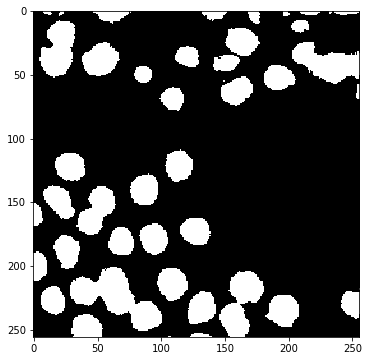

In [11]:
path = "images/test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/images/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png"
img_name = "0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732"

# path = "images/test/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b/images/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b.png"
# img_name = "1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b"

img = cv2.imread(path)
W, H = img.shape[:-1]
X = pre_process_image(img)
y = model.predict(X)
y = (y>0.4).astype(np.uint8)   # the best threshold is 0.4
y = cv2.resize(y[0, :, :, 0], (H, W))

show(y)

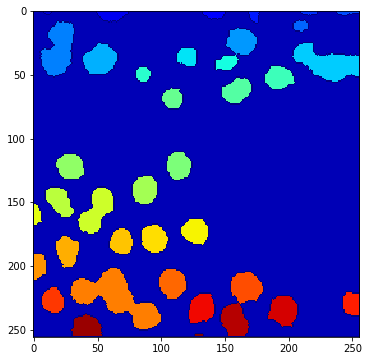

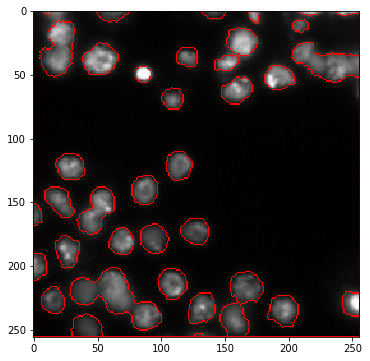

In [12]:
with_morph = False
img = cv2.imread(path)

# show(y)

# noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(y, cv2.MORPH_OPEN, kernel, iterations=2)
opening = opening*255
# show(opening)

# opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, np.ones((25,25), np.uint8))

status="off"
if with_morph:
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7, 7))
    opening=cv2.morphologyEx(opening, cv2.MORPH_OPEN, circle7)
    status="on"

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=1)
# show(sure_bg)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_C, cv2.DIST_MASK_PRECISE)
# show(dist_transform)

ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
# show(sure_fg)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
# show(unknown)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
# show(markers, "jet")

# 
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]
show(markers, "jet")
show(img, "gray")

We can see that the prediction is not so bad. Let's now prepare our prediction on Validation images

# Prediction

Now we have our model, our pre/post processing so we can run the prediction

In [13]:
img_list = []
rle_list = []
kernel = np.ones((3,3), np.uint8)
    
for img in glob.glob("images/test/*/images/*.png"):
    img_name = os.path.basename(img)[:-4]
    img = cv2.imread(img)
    W, H, L = img.shape
    
    # now we have our image, let's predict the mask
    X = pre_process_image(img)
    y = model.predict(X)
    y = (y>0.4).astype(np.uint8)
    
    # let's resize the image to original size
    y = cv2.resize(y[0, :, :, 0], (H, W))
    
    # now we can do the post-processing shown above
    opening = cv2.morphologyEx(y, cv2.MORPH_OPEN, kernel, iterations=2)
    opening = opening*255

    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7, 7))
    opening=cv2.morphologyEx(opening, cv2.MORPH_OPEN, circle7)
    
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_C, cv2.DIST_MASK_PRECISE)
    ret, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(img, markers)
    
    # now for each cells, let's create the RLE encoding
    max_cells = markers.max()
    for i in range(2, max_cells+1):
        mask = (markers==i).astype(np.uint8)
        rle = img_to_rle(mask)
        if len(rle)>0:
            img_list.append(img_name)
            rle_list.append(rle)

In [14]:
# and finally save the dataframe !
df = pd.DataFrame()
df['ImageId'] = img_list
df['EncodedPixels'] = pd.Series(rle_list).apply(lambda x: ' '.join(str(y) for y in x))
df.to_csv('sub-kaggle_model_extended.csv', index=False)

In [18]:
stop = time.time()
print("Time to run the kernel : {:02f}s".format(stop-start))

Time to run the kernel : 984.937022s


# Bonus

During training of Classic Unet and Extended ones, I've saved prediction and save a gif of the training for 4 differents test images. Let's compare both  

<p style="float: left; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="img/training/training_unet-8.gif" style="width: 100%">
</p>

<p style="float: right; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="img/training/training_unet_extended-8.gif" style="width: 100%">
</p>

<p style="float: left; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="img/training/training_unet-11.gif" style="width: 100%">
</p>

<p style="float: right; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="img/training/training_unet_extended-11.gif" style="width: 100%">
</p>

<p style="float: left; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="img/training/training_unet-12.gif" style="width: 100%">
</p>

<p style="float: right; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="img/training/training_unet_extended-12.gif" style="width: 100%">
</p>

<p style="float: left; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="img/training/training_unet-24.gif" style="width: 100%">
</p>

<p style="float: right; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="img/training/training_unet_extended-24.gif" style="width: 100%">
</p>

We can see that the training stabilize clearly faster. Unfortunately some prediction are really bad and decrease a lot the score as only few images are taken in the evalaution